In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  4 02:08:22 2020

@author: stjepan
"""


import numpy as np #required for general computations
from sklearn import preprocessing #for importing pre-processing techniques
from sklearn.feature_selection import chi2, SelectKBest #for feature selection
import matplotlib.pyplot as plt #for plotting the graphs
from sklearn.model_selection import GridSearchCV #for grid search and cross validation

#AES s-box
sbox=(
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16) 

#loading the traces, plaintext, and key from npy
traces = np.load(r'chipwhisperer\traces.npy')
#we take first 10000 traces as 10001 is empty (thus we pre-process)
traces = traces[0:10000]

pt = np.load(r'chipwhisperer\plain.npy')
knownkey = np.load(r'chipwhisperer\key.npy')

HW = [bin(n).count("1") for n in range(256)]

import random

#Function to add desync
def add_desync(traces, desync_level):
    random.seed(42) #Reproducibility
    new_traces = np.empty(traces.shape)
    columns = traces.shape[0]
    for trace in range(columns):
        level = random.randrange(0, desync_level)
        new_col = np.roll(traces[trace,:], -level)
        new_traces[trace,:] = new_col
        
    return new_traces

# We create a new desynced dataset instead of doing it seperately for each run
desync_traces = add_desync(traces, 10)


In [2]:
def break_sub_key(key=0, trainSize = 9000, nAttackTraces = 10, numFeatures = 20, hamming=False, desync=False):
    
    if desync:
        traces_copy = desync_traces
    else:
        traces_copy = traces
    
    #We throw away the first 100 traces since the shift wraps around,
    tracesTrain = traces_copy[100:trainSize+100]
    ptTrain  = pt[100:trainSize+100]

    #for testing, we use 10 traces, always make sure that the traces for training and testing do not overlap
    tracesTest = traces_copy[9990:10000]
    ptTest  = pt[9990:10000]

    #calculate S-box output either hamming or intermediate 
    if hamming:
        outputSbox = [HW[sbox[ptTrain[i][key] ^ knownkey[i][key]]] for i in range(len(ptTrain))] 
    else:
        outputSbox = [sbox[ptTrain[i][key] ^ knownkey[i][key]] for i in range(len(ptTrain))] 


    #Pre-process step: all features are set into [0,1]. For training set, we fit and transform, while for test set, we only transform
    scaler = preprocessing.MinMaxScaler()
    tracesTrain = scaler.fit_transform(tracesTrain)
    tracesTest  = scaler.transform(tracesTest)

    #Feature engineering step: we use chi2 feature selection and take 50 best features. For training set, we fit and transform, while for test set, we only transform
    fs = SelectKBest(score_func=chi2, k=30)
    fs.fit(tracesTrain, outputSbox[0:trainSize])
    tracesTrain = fs.transform(tracesTrain)
    tracesTest = fs.transform(tracesTest)

    #Model selection and hyperparameter tuning. We use SVM and evaluate 4 hyperparameter options
    from sklearn import svm
    parameters = {'kernel':['rbf'], 'C':[0.001, 1], 'gamma':[0.001, 1]}
    SVM = svm.SVC(probability=True) #recall, we need to set probability to True if we want to use predict_proba function that we need to do key rank
    clf = GridSearchCV(SVM, parameters, cv=3, n_jobs=4, scoring='accuracy') #we conduct hyperparameter tuning and cross-validation
    clf.fit(tracesTrain, outputSbox[0:trainSize]) # train the model

    Y_pred_svm = clf.predict_proba(tracesTest) #model validation

    #next, we evaluate the key rank: how many attack traces we need before guessing the correct key
    key_rank = []
    pred = np.zeros(256)
    results = np.zeros(10)
    for i in range(len(tracesTest)): #we evaluate on test traces
        for keyGuess in range(256): #for every possible key guess
            if hamming:
                value = HW[sbox[ptTest[i][key] ^ keyGuess]] #calculate the output of the S-box for that specific attack trace
            else:
                value = sbox[ptTest[i][key] ^ keyGuess] #calculate the output of the S-box for that specific attack trace

            pred[keyGuess] += np.log(Y_pred_svm[i][value]+ 1e-36) #sum the probabilities

        # Calculate key rank
        res = np.argmax(np.argsort(pred)[::-1] == knownkey[key][key]) #to see on what position is the correct guess
        results[i] = res

    print(results)
    return results #We return the positions of the correct guesses

#function to break full key
def break_full_key(hamming=False, desync=False):
    res = np.zeros((16,10))
    for i in range(16):
        print(i)
        res[i,:] = break_sub_key(key=0, hamming=hamming, desync=desync)
        
    return(np.sum(res, 0)) #Sum of the positions of the correct guess per attack trace


In [3]:
#plot the results either with or without desync for hamming and intermediate
def plot_GE_hamming(desync=False):
    res = break_full_key(desync=desync)
    ham_res = break_full_key(hamming=True, desync=desync)
    plt.plot(res, 'r', label='intermediate') 
    plt.plot(ham_res, 'b', label='hamming') 
    plt.legend(loc='upper center', shadow=True, fontsize='x-large')
    plt.xlabel('Number of test traces')
    plt.ylabel('Guessing Entropy')
    plt.title('Guessing Entropy over whole key')
    plt.grid()
    plt.show()

0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
11
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
12
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
14
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
15
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0
[10.  7.  1.  0.  0.  0.  0.  0.  0.  0.]
1
[10.  2.  4.  0.  0.  0.  0.  0.  0.  0.]
2
[10.  2.  0.  0.  0.  0.  0.  0.  0.  0.]
3
[10.  7.  0.  0.  0.  0.  0.  0.  0.  0.]
4
[10.  2.  0.  0.  0.  0.  0.  0.  0.  0.]
5
[10.  2.  0.  0.  0.  0.  0.  0.  0.  0.]
6
[10.  2.  4.  0.  0.  0.  0.  0.  0.  0.]
7
[10.  2.  4.  0.  0.  0.  0.  0.  0.  0.]
8
[10.  2.  0.  0.  0.  0.  0.  0.  0.  0.]
9
[10.  2.  3.  0.  0.  0.  0.  0.  0.  0.]
10
[10.  2

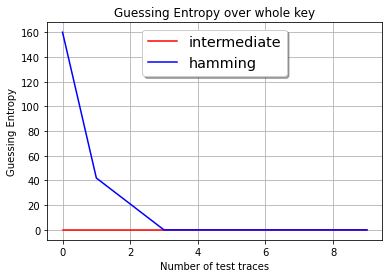

In [4]:
#Create plots
plot_GE_hamming()

0
[ 54.  44.  29.  39.  27. 120. 110. 114. 167. 174.]
1
[ 71. 128.  74.  64.  67. 178. 156. 142. 199. 183.]
2
[ 18.  28.  48.  70.  54. 185. 166. 153. 204. 200.]
3
[ 28.  48.  52.  56.  54. 181. 160. 144. 206. 194.]
4
[ 55.  45.  45.  44.  28. 139. 123. 105. 174. 168.]
5
[ 43.  46.  31.  18.  17. 151. 150.  93. 177. 172.]
6
[ 31.  55.  72.  99.  62. 182. 166. 154. 205. 193.]
7
[  5.  13.  23.  52.  27. 136. 113.  99. 160. 148.]
8
[ 22.  32.  70.  76.  39. 162. 140. 133. 182. 174.]
9
[ 16.  26.  37.  38.  22. 139. 118. 111. 174. 168.]
10
[  4.   3.  16.  23.  18. 129.  99. 102. 157. 155.]
11
[ 61. 109.  55.  21.  17. 142. 132. 126. 188. 185.]
12
[ 19.  12.  20.  34.  25. 144. 119. 105. 159. 160.]
13
[ 22.  29.  28.  19.  30. 118. 111.  98. 158. 153.]
14
[  7.   6.  10.  13.   7. 108. 118. 108. 171. 169.]
15
[ 66.  96.  82.  71.  85. 208. 173. 178. 223. 218.]
0
[191. 133.  95. 161. 138. 123.  97. 181. 204. 218.]
1
[191. 136.  98. 167. 143. 130. 108. 191. 212. 223.]
2
[191. 130. 103. 166.

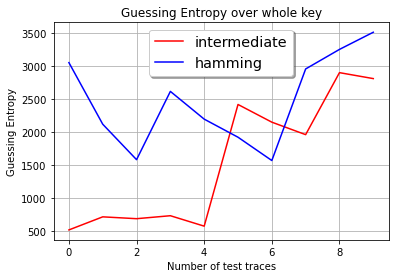

In [6]:
#Create plots
plot_GE_hamming(desync=True)